In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib  # Model save karne ke liye

print("Libraries Loaded Successfully.")

Libraries Loaded Successfully.


In [2]:
# Data load karna
data = pd.read_excel("Online Retail.xlsx")
print(f"Data Loaded. Shape: {data.shape}")

Data Loaded. Shape: (541909, 8)


In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
print(data.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [5]:
# 1. Missing values hatana
data = data.dropna()

# 2. Outliers hatana (Negative Quantity/Price) aur Copy banana (Warning Fix)
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)].copy()

print("Cleaning Done. New Shape:", data.shape)

Cleaning Done. New Shape: (397884, 8)


In [6]:
# Total Amount banana
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']

# Date format fix karna
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

print("Features Added.")
data.head()

Features Added.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


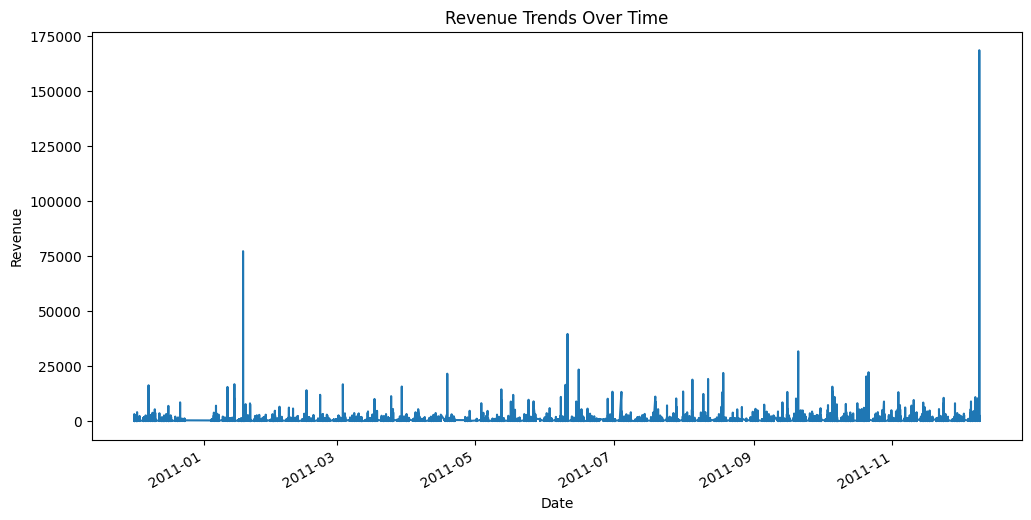

In [7]:
# Date ke hisab se Revenue plot karna
plt.figure(figsize=(12, 6))
data.groupby('InvoiceDate')['TotalAmount'].sum().plot()
plt.title('Revenue Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

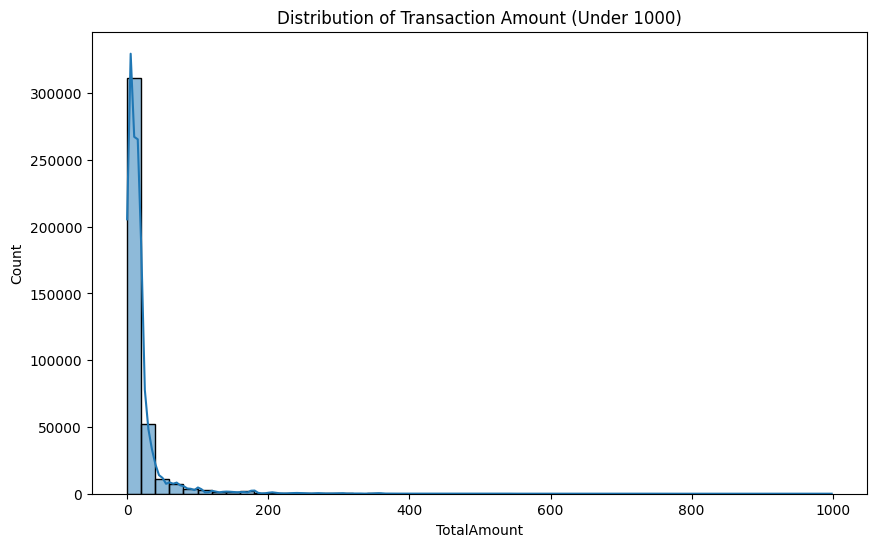

In [8]:
# Zyada bada data hai isliye hum filtered data dikhayenge (< 1000) clear dikhne ke liye
plt.figure(figsize=(10, 6))
sns.histplot(data[data['TotalAmount'] < 1000]['TotalAmount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amount (Under 1000)')
plt.show()

In [9]:
# Reference date set karna
latest_date = data['InvoiceDate'].max() + dt.timedelta(days=1)

# RFM Calculation
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days, # Recency
    'InvoiceNo': 'count',                                  # Frequency
    'TotalAmount': 'sum'                                   # Monetary
}).reset_index()

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
}, inplace=True)

print("RFM Table Created.")
rfm.head()

RFM Table Created.


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40


In [10]:
# 1. Features select karna
features = rfm[['Recency', 'Frequency', 'Monetary']]

# 2. Scaling (Ye step purani notebook mein missing tha)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(features)

# 3. K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 4. Save Scaler & KMeans Model (App ke liye)
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(kmeans, 'kmeans_model.pkl')

print("Clustering Done & Models Saved.")
print(rfm['Cluster'].value_counts())

Clustering Done & Models Saved.
Cluster
0    2171
1    1326
3     828
2      13
Name: count, dtype: int64


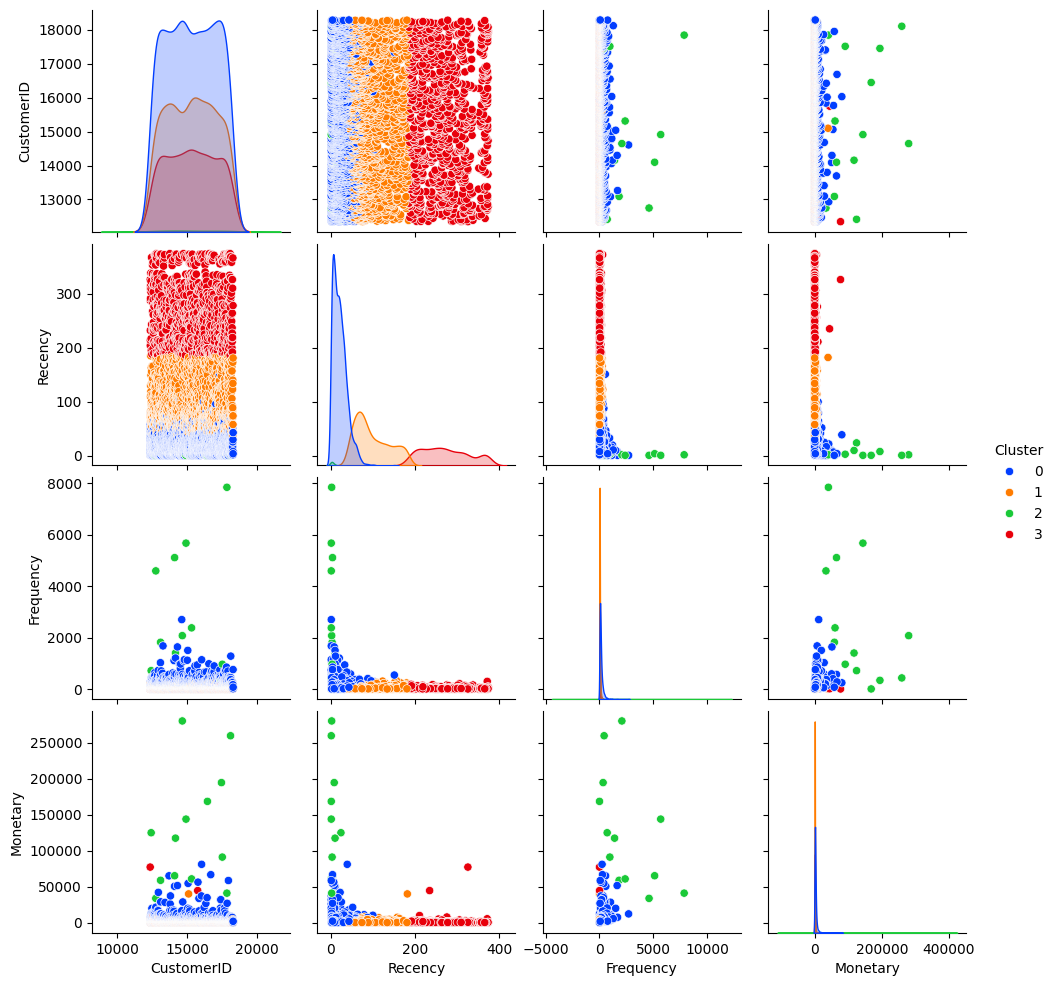

In [11]:
# Clusters ko visualize karna
sns.pairplot(rfm, hue='Cluster', palette='bright')
plt.show()

In [12]:
# Features (X) aur Target (y)
X = rfm[['Recency', 'Frequency', 'Cluster']] # Inputs
y = rfm['Monetary']                          # Output (Paisa)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data Split Done.")

Data Split Done.


In [13]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prediction check
y_pred = rf_model.predict(X_test)

# Evaluation
print("Random Forest Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")

Random Forest Performance:
MAE: 1978.9995460010246
RMSE: 9156.591667121673
R2 Score: 0.1815613703371447


In [14]:
# Revenue Prediction model ko save karna
joblib.dump(rf_model, 'revenue_model.pkl')

print("✅ All Steps Completed.")
print("Files Generated: 'scaler.pkl', 'kmeans_model.pkl', 'revenue_model.pkl'")

✅ All Steps Completed.
Files Generated: 'scaler.pkl', 'kmeans_model.pkl', 'revenue_model.pkl'


In [15]:
%%writefile app.py
import streamlit as st
import numpy as np
import joblib

# ==========================================
# 1. LOAD SAVED MODELS
# ==========================================
try:
    scaler = joblib.load('scaler.pkl')
    kmeans_model = joblib.load('kmeans_model.pkl')
    rf_model = joblib.load('revenue_model.pkl')
except FileNotFoundError:
    st.error("Error: Model files not found! Please run 'training.ipynb' first.")
    st.stop()

# ==========================================
# 2. APP UI (User Interface)
# ==========================================
st.set_page_config(page_title="Revenue Predictor", layout="centered")

st.title("💰 Customer Revenue Prediction")
st.write("Enter customer details to predict their potential revenue value.")

# Input Form
with st.form("prediction_form"):
    st.subheader("Customer Details (RFM)")
    
    # Recency input
    recency = st.number_input("Days Since Last Purchase (Recency)", 
                              min_value=0, value=10, help="Kam din matlab accha customer")
    
    # Frequency input
    frequency = st.number_input("Total Transactions (Frequency)", 
                                min_value=1, value=5, help="Zyada baar matlab loyal customer")
    
    # Monetary input
    monetary = st.number_input("Total Spent So Far (Monetary)", 
                               min_value=0.0, value=500.0, format="%.2f")
    
    submit_btn = st.form_submit_button("Predict Future Value")

# ==========================================
# 3. PREDICTION LOGIC
# ==========================================
if submit_btn:
    try:
        # Step A: Data ko format karna
        raw_data = np.array([[recency, frequency, monetary]])
        
        # Step B: Scaling
        scaled_data = scaler.transform(raw_data)
        
        # Step C: Clustering
        cluster = kmeans_model.predict(scaled_data)[0]
        
        # Step D: Regression Prediction
        # Model input: Recency, Frequency, Cluster
        model_input = np.array([[recency, frequency, cluster]])
        
        prediction = rf_model.predict(model_input)[0]
        
        # ==========================================
        # 4. DISPLAY RESULTS
        # ==========================================
        st.success(f"✅ Prediction Complete!")
        
        col1, col2 = st.columns(2)
        
        with col1:
            st.metric(label="Assigned Cluster", value=f"Cluster {cluster}")
            
        with col2:
            st.metric(label="Predicted Revenue Value", value=f"₹ {prediction:.2f}")
            
        if prediction > monetary:
            st.info("📈 This customer is expected to spend MORE in the future!")
        else:
            st.warning("📉 This customer might reduce spending. Requires attention.")
            
    except Exception as e:
        st.error(f"An error occurred: {e}")

# Footer
st.markdown("---")
st.caption("Built with Random Forest & K-Means Clustering")

Writing app.py


In [16]:
%%writefile requirements.txt
pandas
numpy
scikit-learn
streamlit
joblib
openpyxl
matplotlib
seaborn

Writing requirements.txt
